In [2]:
import os
import torch
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from pandas.tseries.holiday import USFederalHolidayCalendar

In [3]:
R_STATE = 76
TEST_SIZE = 0.15
N_THREADS = 4
N_FOLDS = 5
TIMEOUT = 300

In [4]:
np.random.seed(R_STATE)

# Additional data

In [8]:
# weather data = 'https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016'

weather = pd.read_csv('data/weather.csv')
weather.head(3)

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0


# Reading data from dataset

In [9]:
# train

df = pd.read_csv('data/train.csv')
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [10]:
# test

test_set = pd.read_csv('data/train.csv')
test_set.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [12]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 366 non-null    object 
 1   maximum temperature  366 non-null    int64  
 2   minimum temperature  366 non-null    int64  
 3   average temperature  366 non-null    float64
 4   precipitation        366 non-null    object 
 5   snow fall            366 non-null    object 
 6   snow depth           366 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 20.1+ KB


# EDA

latitude [min= 34.35969543457031, max= 51.88108444213867]


<AxesSubplot:ylabel='pickup_latitude'>

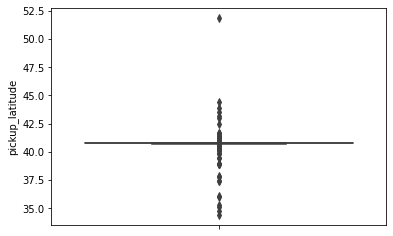

In [49]:
print(f'latitude [min= {df.pickup_latitude.min()}, max= {df.pickup_latitude.max()}]')

sns.boxplot(data= df, y= df.pickup_latitude)

latitude [min= -121.93334197998048, max= -61.33552932739258]


<AxesSubplot:ylabel='pickup_longitude'>

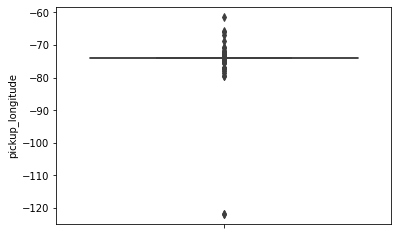

In [50]:
print(f'latitude [min= {df.pickup_longitude.min()}, max= {df.pickup_longitude.max()}]')

sns.boxplot(data= df, y= df.pickup_longitude)

Text(0.5, 1.0, 'Test set')

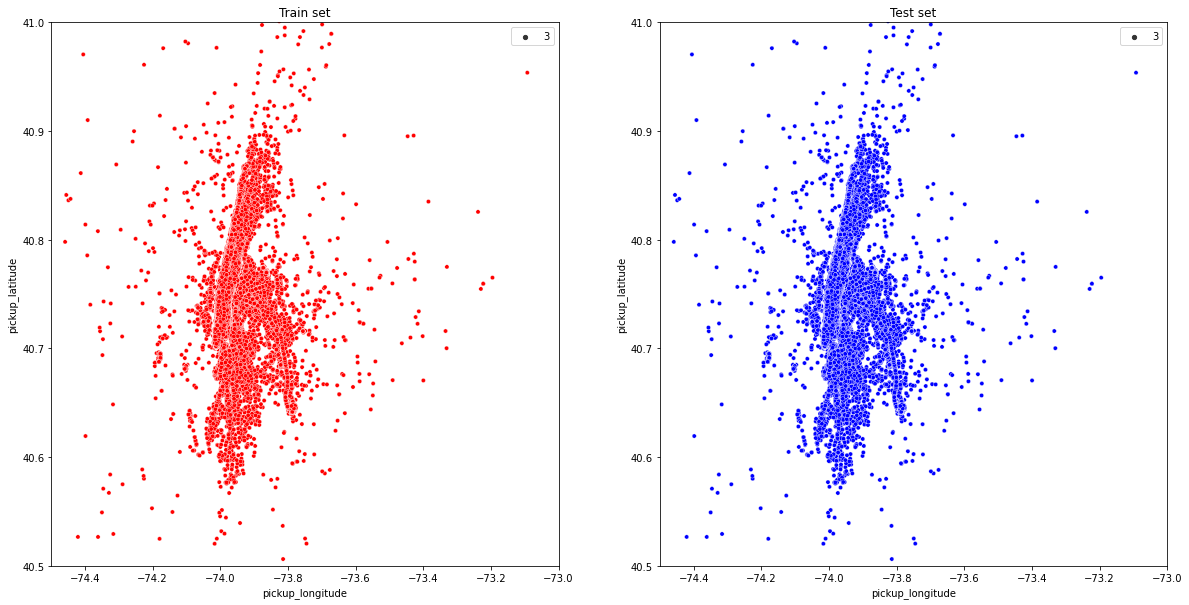

In [58]:
fig, axs = plt.subplots(1,2, figsize= (20,10))


axs[0].set_xlim([-74.5, -73])
axs[0].set_ylim([40.5, 41])

axs[1].set_xlim([-74.5, -73])
axs[1].set_ylim([40.5, 41])

sns.scatterplot(data= df, x= df.pickup_longitude, y= df.pickup_latitude, size=3, ax= axs[0], color= 'red').set_title('Train set')
sns.scatterplot(data= df, x= test_set.pickup_longitude, y= test_set.pickup_latitude, size=3, ax= axs[1], color= 'blue').set_title('Test set')

### NOTE: train and test sets are homogenious